In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import History

In [3]:
data_dir = "/content/drive/MyDrive/ThiGiacMay/btl/char_bien_so"

In [4]:
# Hàm tiền xử lý ảnh: đổi ảnh thành grayscale và chuẩn hóa
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))  # Đổi kích thước ảnh
    img = img / 255.0  # Chuẩn hóa giá trị pixel
    return img

In [5]:
path_test = "/content/drive/MyDrive/ThiGiacMay/btl/char_bien_so/0/1345_2.jpg"
img_test = cv2.imread(path_test)
cv2_imshow(img_test)

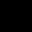

[[0.00392157 0.01568627 0.08627451 ... 0.00392157 0.00784314 0.00784314]
 [0.1254902  0.13333333 0.19215686 ... 0.         0.         0.        ]
 [0.14117647 0.15294118 0.21176471 ... 0.00392157 0.00392157 0.00392157]
 ...
 [0.00392157 0.00392157 0.         ... 0.2745098  0.25098039 0.24705882]
 [0.         0.         0.         ... 0.19215686 0.14509804 0.1372549 ]
 [0.         0.         0.00784314 ... 0.05098039 0.00784314 0.        ]]


In [6]:
te = preprocess_image(path_test)
cv2_imshow(te)
print(np.array(te))

In [7]:
# Hàm chuẩn bị dữ liệu
def prepare_data(data_dir):
    images = []
    labels = []
    label_dict = {}  # Lưu nhãn tương ứng với các thư mục
    label_id = 0  # Khởi tạo nhãn bắt đầu từ 0

    # Đọc ảnh từ các thư mục trong bộ dữ liệu
    for folder in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            label_dict[label_id] = folder  # Gán nhãn cho từng thư mục
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                img = preprocess_image(image_path)
                images.append(img)
                labels.append(label_id)
            label_id += 1  # Tăng nhãn cho thư mục tiếp theo

    # Chuyển danh sách ảnh và nhãn thành numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_dict

In [8]:
# Chuẩn bị dữ liệu
images, labels, label_dict = prepare_data(data_dir)

In [9]:
# In ra thông tin về dữ liệu
print("Total number of images:", len(images))
print("Label Dictionary:", label_dict)

Total number of images: 3100
Label Dictionary: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L', 20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}


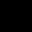

0


In [10]:
cv2_imshow(images[0])
print(label_dict[0][0])

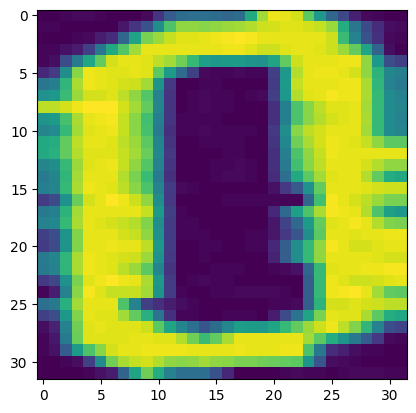

Label: [[0.         0.         0.00392157 ... 0.00392157 0.         0.        ]
 [0.00392157 0.00392157 0.         ... 0.03921569 0.01176471 0.00784314]
 [0.         0.         0.         ... 0.04313725 0.00784314 0.00392157]
 ...
 [0.00392157 0.01568627 0.09019608 ... 0.00392157 0.         0.        ]
 [0.         0.         0.00392157 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00784314 0.00392157 0.00392157]]


In [11]:
import matplotlib.pyplot as plt

image = images[0]
label = labels[0]

# Hiển thị ảnh bằng matplotlib để kiểm tra
plt.imshow(image)  # Đảm bảo ảnh đúng màu
plt.show()

# In ra nhãn
print("Label:", image)

In [12]:
from sklearn.model_selection import train_test_split
# Chia dữ liệu thành 80% train và 20% test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [13]:
# from torch.utils.data import DataLoader, Dataset
# # tạo dataloader
# batch_size = 32
# train_loader = DataLoader(X_train, y_train, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(X_test, y_test, batch_size=batch_size, shuffle=False)

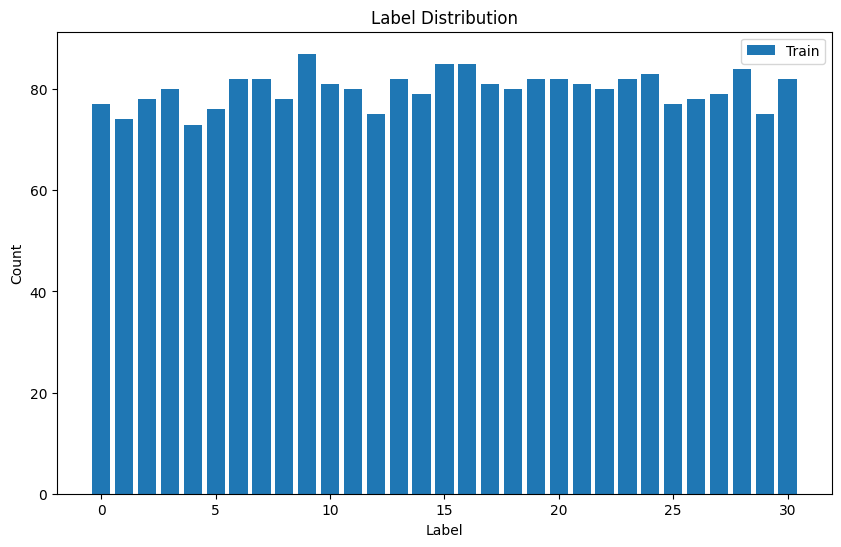

In [14]:
# Kiểm tra số lượng nhãn trong tập huấn luyện (X_train) và kiểm tra (X_test)
train_labels_count = np.unique(y_train, return_counts=True)
test_labels_count = np.unique(y_test, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(train_labels_count[0], train_labels_count[1], label='Train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [15]:
# Định nghĩa mô hình CNN
model = models.Sequential([
    layers.InputLayer(input_shape=(32, 32, 1)),  # Ảnh grayscale 32x32
    layers.Conv2D(18, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_dict), activation='softmax')  # Số lớp = số ký tự
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1308 - loss: 3.2059
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8210 - loss: 0.6211
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9129 - loss: 0.2844
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9509 - loss: 0.1796
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9595 - loss: 0.1355
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9569 - loss: 0.1390
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9657 - loss: 0.1295
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9692 - loss: 0.0911
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9743 - loss: 0.0825
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9748 - loss: 0.0737


In [18]:
# Đánh giá mô hình
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9654 - loss: 0.1741
Test accuracy: 95.97%


In [19]:
# Lưu mô hình
model.save('license_plate_recognition_model.h5')

In [20]:
from google.colab import files
files.download('license_plate_recognition_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import time

# Dự đoán từ ảnh mới
def predict_from_image(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Thêm chiều batch
    img = np.expand_dims(img, axis=-1)  # Thêm chiều kênh (1 cho ảnh grayscale)

    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)[0]  # Dự đoán nhãn
    return label_dict[predicted_label]  # Trả về ký tự dự đoán

# Ví dụ sử dụng dự đoán
image_path = "/content/Screenshot 2025-04-06 142736.png"
start_time = time.time()
predicted_char = predict_from_image(image_path)
end_time = time.time()
print(f'time for predict: {end_time - start_time}')
print(f"Predicted Character: {predicted_char}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
time for predict: 0.20066094398498535
Predicted Character: 5


# Finetune
